In [1]:
from utils import helper
import matplotlib.pyplot as plt
from IPython.display import display, HTML
plt.style.use("ggplot")

# define macros
ORIGINAL_DATA_PATH = '/Users/brikerman/Downloads/殆知阁古代文献藏书/史藏/编年'
TARGET_DATA_PATH = '/Users/brikerman/Desktop/daizhige/史藏/编年'

MAX_SEQUENCE_LENGTH = 100
EPOCHS = 5
BATCH_SIZE = 200

Using TensorFlow backend.


## 数据预处理

### 提取有标点的数据集

原数据没有区分那些数据是有标点，那些数据是没有标点。所以我们的第一部是区分有标点和没有标点的数据集。
目前这里采取了很简单粗暴的方案，看一篇文章中汉字和标点的比例，即 标点符号数量 / (汉字数量 + 标点符号数量) 当比例大于 0.1 则判断为有标点符号。

In [2]:
from utils import split_data
split_data.split_marked_unmarked_files(ORIGINAL_DATA_PATH, TARGET_DATA_PATH)

generating file info: 100%|██████████| 50/50 [00:30<00:00,  1.03it/s]
copying files to /Users/brikerman/Desktop/daizhige/史藏/编年/marked: 100%|██████████| 17/17 [00:00<00:00, 109.67it/s]
copying files to /Users/brikerman/Desktop/daizhige/史藏/编年/unmarked: 100%|██████████| 33/33 [00:00<00:00, 180.32it/s]


In [3]:
# 读取文件信息 csv 并展示
import pandas as pd
df = pd.read_csv('./file_info.csv')
display(HTML(df.to_html()))

,Unnamed: 0,chinese_count,file,mark_count,mark_list,mark_rate,token_count
0,0,21511,/唐创业起居注.txt,40,【 】,0.001856,21551
1,1,1109583,/宋史全文.txt,189051,。 【 “ ， 、 《 》 ？ ○ ” ： ） ； （ 】,0.145577,1298634
2,2,265255,/中兴小纪.txt,468,【 】,0.001761,265723
3,3,10180,/资治通鉴目录.txt,10,【 】,0.000981,10190
4,4,117063,/竹书纪年辑证.txt,38189,。 【 “ ； ， 、 《 》 ？ ” ： ） 】 （ ○,0.245981,155252
5,5,278425,/西汉年纪.txt,7082,【 】,0.024805,285507
6,6,458039,/九朝编年备要.txt,567,【 】 ○,0.001236,458606
7,7,2095,/资治通鉴释例.txt,24,【 】,0.011326,2119
8,8,74946,/元经.txt,5707,。 ， 、 ？ ： ；,0.070760,80653
9,9,47982,/郑史编年辑录.txt,12705,。 “ ， 、 《 》 ？ ” ： ） ； （,0.209353,60687


### 数据 token 化

这里我自己写了个 Tokenizer，支持直接 tokenize 数据或者利用预训练的词向量模型，关于如何预训练词向量我晚些时候补上。

In [4]:
import os
from utils.tokenizer import Tokenizer

# 构建 tokenizer，只需要构建一次
tokenizer = Tokenizer()
# tokenizer.build(corpus_path=ORIGINAL_DATA_PATH, tokenizer_path='./data/embedding/')

# 加载 tokenizer 数据
tokenizer.load('./data/embedding/')

In [ ]:
# token 化数据
marked_file_path = os.path.join(TARGET_DATA_PATH, 'marked')
tokenizer.max_length = MAX_SEQUENCE_LENGTH
files_info = tokenizer.tokenize_files(files_path=marked_file_path,
                                      data_path='./data')

processing files: 100%|██████████| 17/17 [00:36<00:00,  2.74s/it]

-------- tokenize data finished --------
dataset path : /Users/brikerman/Desktop/ailab/classic_chinese_punctuate/data/dataset.h5
sample x     : [   6   40  291    9  141  372   13  417  434   83   46   14 1005  149
   17   91 1872   89   36  324  660   89  529  106   43   31   89   52
  113   50   49  114   28 2657 3015  102  153   11   24  661   72  252
  407   11   21   45   72  291  685  470   95   12   56 1115   17   46
 1923  293   36    9  270   53  212  230 1247  572  528 1113   24   40
   11  246   31  168   58  230   35   54   30  511  657  100  351   45
  410  253   45    9  175   51    6  270  573 2082  651   28  210  510
  384    2]
sample y     : [ 1  2  1  1  1  1  1  2  1  1  1  1  1  1  3  1  1  1  1  1  2  2  1  1
 10  1  1  1  3  1  1  1  1  1  1  1  1  7  1  1  1  1  1  7  1  1  2  1
  1  1  1  2  1  1  1  1  2  1  1  1  2  1  1  3  1  1  1  1  1  1  7  1
  1  1  1  1  1  1  2  1  1  1  1  1  1  3  1  1  1  1  1  2  1  1  1  1
  1  1  1  1]
--------------------------

### 简单可视化分析数据长度

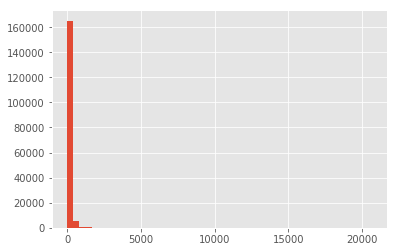

In [ ]:
plt.hist(files_info['length'], bins=50)
plt.show()

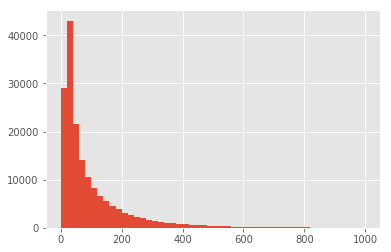

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist(files_info['length'], bins=50, range=(0, 1000))
plt.show()

## 构建模型

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import InputLayer
from keras.layers import Dropout
from keras.layers import Activation


if tokenizer.w2v:
    print('use pre embedded embedding layer')
    embedding_layer = Embedding(len(tokenizer.w2v.embedding_matrix),
                            tokenizer.w2v.embedding_size,
                            weights=[tokenizer.w2v.embedding_matrix],
                            trainable=False)
else:
    print('embed while training')
    embedding_layer = Embedding(len(tokenizer.word2idx), 50)

model = Sequential()
model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH, )))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(len(tokenizer.labels2idx))))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

embed while training
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           528350    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          628736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 17)           8721      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 17)           0         
Total params: 1,165,807
Trainable params: 1,165,807
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import h5py
from sklearn.model_selection import train_test_split

dataset = h5py.File('./data/dataset.h5', 'r')

train_idx, test_idx = train_test_split(range(len(dataset['x'])), test_size=0.15)

train_generator = helper.h5f_generator(h5path='./data/dataset.h5',
                                       indices=train_idx,
                                       label_count=len(tokenizer.labels2idx),
                                       batch_size=200)

test_generator = helper.h5f_generator(h5path='./data/dataset.h5',
                                      indices=test_idx,
                                      label_count=len(tokenizer.labels2idx),
                                      batch_size=200)

model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_idx) // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[],
                    validation_data=test_generator,
                    validation_steps=len(test_idx) // BATCH_SIZE)


Epoch 1/5
 20/728 [..............................] - ETA: 30:57 - loss: 1.7623 - acc: 0.5510

## 使用模型预测

In [ ]:
import keras
model = keras.models.load_model('/Users/brikerman/Desktop/ailab/wenyanwen/data/model/model.model',  # type: keras.models.Sequential
                                           custom_objects={'loss': loss_f})
for text in [
    '余谓拯饥之政富郑公在青州为百世师仿其意而行之在后贤焉兴赈田'
                         '之利除赈籴之害今日事矣除害于今未必不生害于后特举其槩与诸大'
                         '夫国人议之或曰黔之天时繁阴雨山溜洒泉可资濯溉不若中原赤地千'
                         '里之田也'
]:
    r = helper.predict_with_model(tokenizer=tokenizer, model=model, text=text)
    print(r)